In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#### Algorithm

In [2]:
class LogisticRegression:
    def __init__(self, X, y):
        self._X = np.column_stack((np.ones((X.shape[0], 1)), X))
        self._y = y
        self._weights = np.random.uniform(-1, 1, size=self._X.shape[1])
        self._weights_history = []
        self._errors_history = []
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x)) 
    
    def train(self, max_epochs=1000, alpha=0.5):
        for epoch in range(max_epochs):
            weighted_sum = np.dot(self._X, self._weights)
            predictions = self.sigmoid_function(weighted_sum)
            gradients = np.dot(self._X.T, predictions - self._y) / self._X.shape[0]
            
            self._weights -= alpha * gradients
            self._weights_history.append(self._weights.copy())
            error = -np.sum(self._y * np.log10(np.add(predictions, 1e-7)) + (1 - self._y) * np.log10(np.subtract(1, predictions) + 1e-7))
            self._errors_history.append(error)
            
    def predict(self, X):
        x_with_bias = np.column_stack((np.ones((X.shape[0], 1)), X))
        return np.array([1 if self.sigmoid_function(x) > 0.5 else 0 for x in np.dot(x_with_bias, self._weights)])
    
    def get_weights_history(self):
        return self._weights_history
    
    def get_errors_history(self):
        return self._errors_history

#### Load data

In [3]:
df = pd.read_csv('Ankieta.csv')
df.head()

,Waga,Wzrost,Plec
0,55,160,Kobieta
1,78,180,Mezczyzna
2,55,150,Kobieta
3,99,196,Mezczyzna
4,90,180,Mezczyzna


In [4]:
X = np.array([df['Waga'].values, df['Wzrost'].values]).T
X_scaled = MinMaxScaler().fit_transform(X)

mapping = {'Kobieta':0, 'Mezczyzna':1}
y = np.vectorize(mapping.get)(df['Plec'])

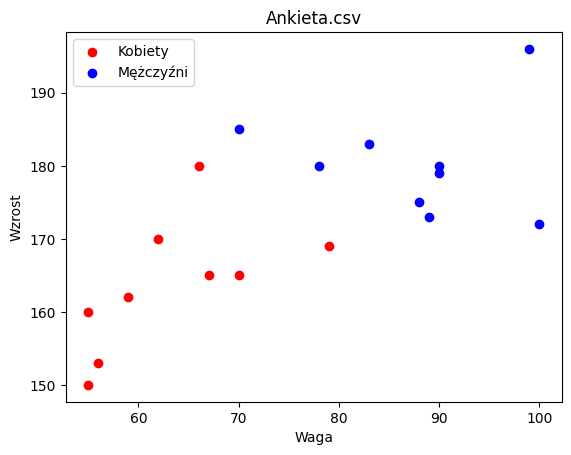

In [5]:
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], c = 'red', label='Kobiety')
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c = 'blue', label='Mężczyźni')

plt.title("Ankieta.csv")
plt.xlabel("Waga")
plt.ylabel("Wzrost")
plt.legend()
plt.show()

#### Training model

In [6]:
logistic_regression = LogisticRegression(X_scaled, y)
logistic_regression.train(max_epochs=10000)

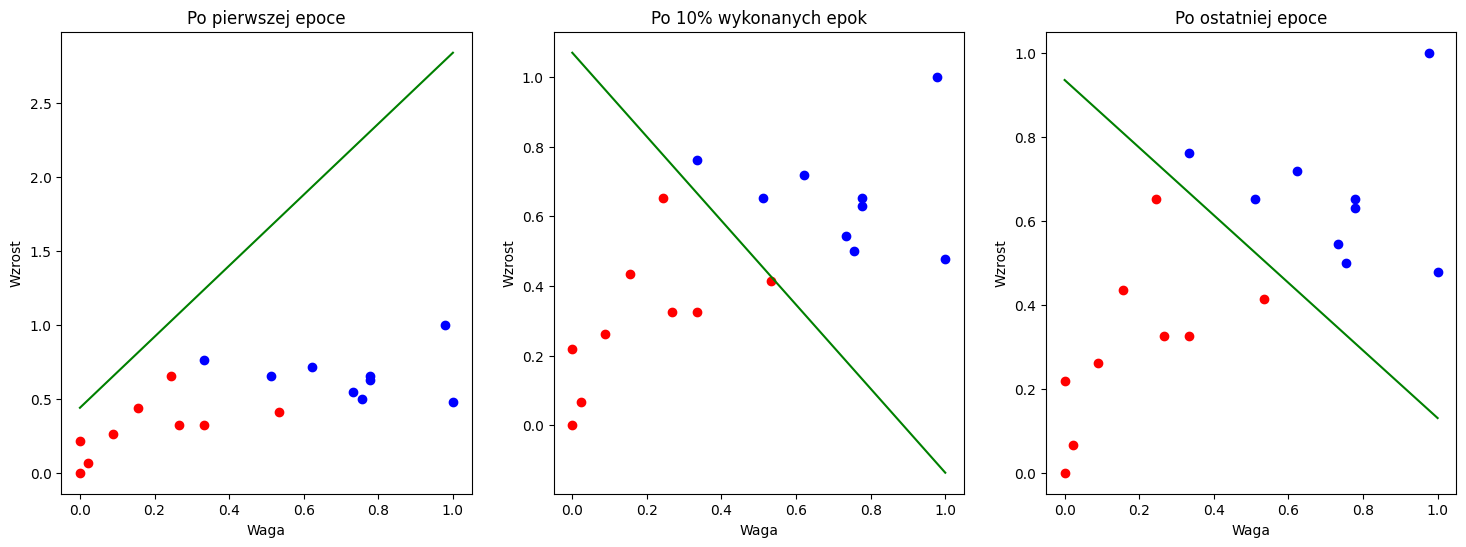

In [7]:
_, axs = plt.subplots(1, 3, figsize=(18, 6))

weights_history = logistic_regression.get_weights_history()
weights_first = weights_history[0]
weights_middle = weights_history[len(weights_history) // 10]
weights_last = weights_history[-1]

x = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 10)
y_first = -(weights_first[1] * x + weights_first[0]) / weights_first[2]
y_middle = -(weights_middle[1] * x + weights_middle[0]) / weights_middle[2]
y_last = -(weights_last[1] * x + weights_last[0]) / weights_last[2]

axs[0].scatter(X_scaled[:, 0][y == 0], X_scaled[:, 1][y == 0], c = 'red', label='Kobiety')
axs[0].scatter(X_scaled[:, 0][y == 1], X_scaled[:, 1][y == 1], c = 'blue', label='Mężczyźni')
axs[0].plot(x, y_first, color='green', label='Granica decyzyjna')
axs[0].set_xlabel('Waga')
axs[0].set_ylabel('Wzrost')
axs[0].set_title('Po pierwszej epoce')

axs[1].scatter(X_scaled[:, 0][y == 0], X_scaled[:, 1][y == 0], c = 'red', label='Kobiety')
axs[1].scatter(X_scaled[:, 0][y == 1], X_scaled[:, 1][y == 1], c = 'blue', label='Mężczyźni')
axs[1].plot(x, y_middle, color='green', label='Granica decyzyjna')
axs[1].set_xlabel('Waga')
axs[1].set_ylabel('Wzrost')
axs[1].set_title('Po 10% wykonanych epok')

axs[2].scatter(X_scaled[:, 0][y == 0], X_scaled[:, 1][y == 0], c = 'red', label='Kobiety')
axs[2].scatter(X_scaled[:, 0][y == 1], X_scaled[:, 1][y == 1], c = 'blue', label='Mężczyźni')
axs[2].plot(x, y_last, color='green', label='Granica decyzyjna')
axs[2].set_xlabel('Waga')
axs[2].set_ylabel('Wzrost')
axs[2].set_title('Po ostatniej epoce')

plt.show()

#### Comparison with Perceptron

In [8]:
class PerceptronBenchmark:
    def __init__(self, X, y):
        self._X = np.column_stack((np.ones((X.shape[0], 1)), X))
        self._y = y
        self._weights = np.random.uniform(-1, 1, size=self._X.shape[1])
        
    def heaviside_function(self, x):
        return 1 if x >= 0 else 0
    
    def train(self, max_epochs=1000, alpha=0.1, verbose=False, early_stopping=True):
        epoch = 1
        while epoch <= max_epochs:
            misclassified = 0
            for sample, label in zip(self._X, self._y):
                weighted_sum = np.dot(sample, self._weights)
                prediction = self.heaviside_function(weighted_sum)
                
                if label != prediction:
                    misclassified += 1
                    self._weights += alpha * (label - prediction) * sample
                    
            if misclassified == 0 and early_stopping:
                if verbose: print(f'Perceptron converged in #{epoch} epoch. Stop training.')
                break
                
            epoch += 1
            
class LogisticRegressionBenchmark:
    def __init__(self, X, y):
        self._X = np.column_stack((np.ones((X.shape[0], 1)), X))
        self._y = y
        self._weights = np.random.uniform(-1, 1, size=self._X.shape[1])
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x)) 
    
    def train(self, max_epochs=1000, alpha=0.1, verbose=False, early_stopping=True):
        for epoch in range(max_epochs):
            weighted_sum = np.dot(self._X, self._weights)
            predictions = self.sigmoid_function(weighted_sum)
            gradients = np.dot(self._X.T, predictions - self._y) / self._X.shape[0]
            
            self._weights -= alpha * gradients
            
            if early_stopping and np.sum(self.predict(self._X, add_bias=False) == self._y) == len(self._X):
                if verbose: print(f'Logistic regressor converged in #{epoch} epoch. Stop training.')
                break
            
    def predict(self, X, add_bias=True):
        x = np.column_stack((np.ones((X.shape[0], 1)), X)) if add_bias else X
        return np.array([1 if self.sigmoid_function(x) > 0.5 else 0 for x in np.dot(x, self._weights)])

In [9]:
print('Uruchomienie próbne:')
perceptron_benchmark = PerceptronBenchmark(X_scaled, y); perceptron_benchmark.train(verbose=True)
logistic_regression_benchmark = LogisticRegressionBenchmark(X_scaled, y); logistic_regression_benchmark.train(verbose=True)

print('Pomiar czasu (koniec uczenia następuje natychmiast po prawidłowym sklasyfikowaniu wszystkich próbek):')
%timeit perceptron_benchmark = PerceptronBenchmark(X_scaled, y); perceptron_benchmark.train()
%timeit logistic_regression_benchmark = LogisticRegressionBenchmark(X_scaled, y); logistic_regression_benchmark.train()

print('Pomiar czasu (koniec uczenia po wykonaniu wszystkich epok):')
%timeit perceptron_benchmark = PerceptronBenchmark(X_scaled, y); perceptron_benchmark.train(early_stopping=False)
%timeit logistic_regression_benchmark = LogisticRegressionBenchmark(X_scaled, y); logistic_regression_benchmark.train(early_stopping=False)

Uruchomienie próbne:
Perceptron converged in #19 epoch. Stop training.
Pomiar czasu (koniec uczenia następuje natychmiast po prawidłowym sklasyfikowaniu wszystkich próbek):
308 μs ± 4.09 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
26 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Pomiar czasu (koniec uczenia po wykonaniu wszystkich epok):
14.2 ms ± 223 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.94 ms ± 22.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 3D decision plane

In [10]:
df = pd.read_csv("3D_perceptron.csv")
df.head()

X = np.array([df['x1'].values, df['x2'].values, df['x3'].values]).T
y = df['y'].values

X_scaled = MinMaxScaler().fit_transform(X)

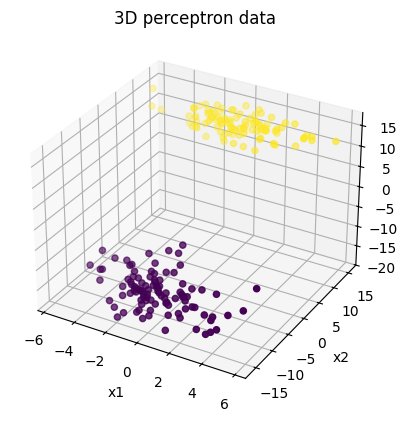

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('3D perceptron data')

plt.show()

In [12]:
logistic_regression = LogisticRegression(X_scaled, y)
logistic_regression.train(max_epochs=1000, alpha=0.1)
print(f'Poprawnie sklasyfikowanych: {np.count_nonzero(logistic_regression.predict(X_scaled) == y)} / {len(y)}')

Poprawnie sklasyfikowanych: 200 / 200


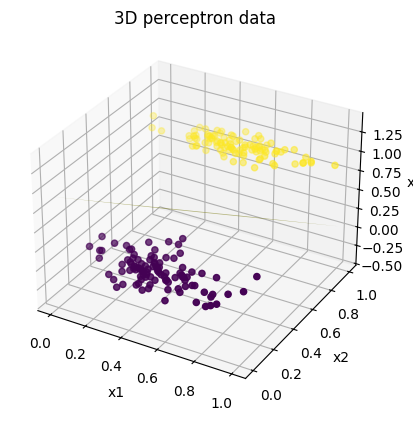

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

weights = logistic_regression.get_weights_history()[-1]

x1, x2 = np.meshgrid(np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 10),
                    np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 10))
x3 = -(weights[0] + weights[1] * x1 + weights[2] * x2) / weights[3]

ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y)
ax.plot_surface(x1, x2, x3, alpha=0.5, rstride=100, cstride=100, color='y')
    
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('3D perceptron data')

plt.show()

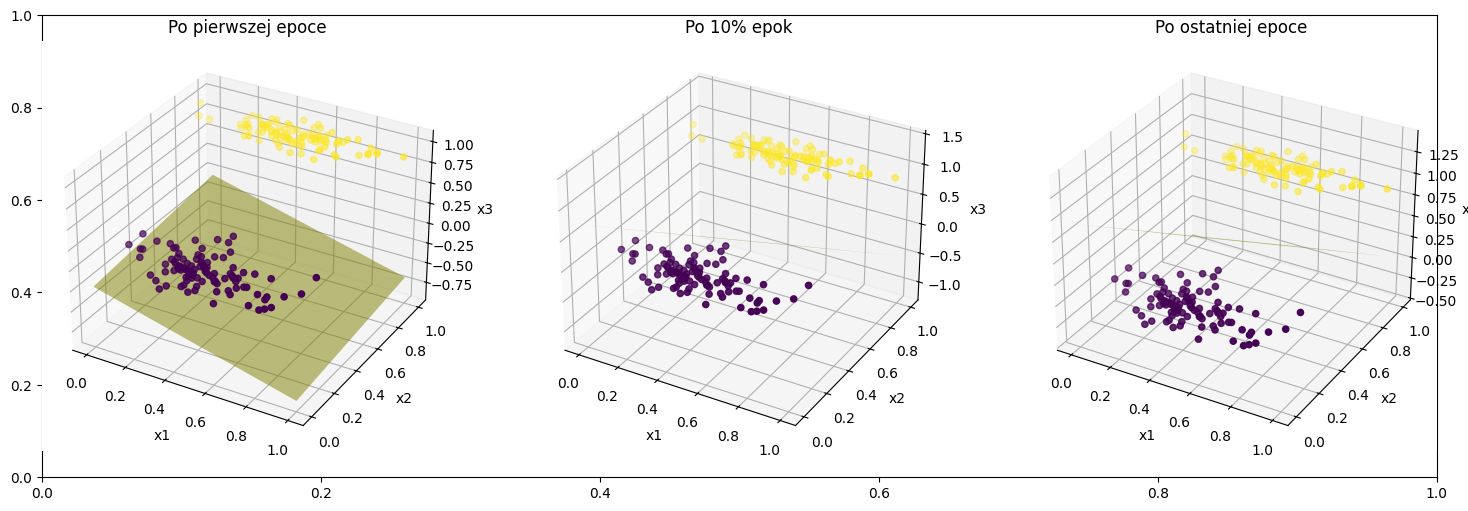

In [14]:
fig, _ = plt.subplots(figsize=(18, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

weights_history = logistic_regression.get_weights_history()
weights_first = weights_history[0]
weights_middle = weights_history[len(weights_history) // 10]
weights_last = weights_history[-1]

x1, x2 = np.meshgrid(np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 10),
                    np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 10))

x3 = -(weights_first[0] + weights_first[1] * x1 + weights_first[2] * x2) / weights_first[3]
ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y)
ax1.plot_surface(x1, x2, x3, alpha=0.5, rstride=100, cstride=100, color='y')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('x3')
ax1.set_title('Po pierwszej epoce')

x3 = -(weights_middle[0] + weights_middle[1] * x1 + weights_middle[2] * x2) / weights_middle[3]
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y)
ax2.plot_surface(x1, x2, x3, alpha=0.5, rstride=100, cstride=100, color='y')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('x3')
ax2.set_title('Po 10% epok')

x3 = -(weights_last[0] + weights_last[1] * x1 + weights_last[2] * x2) / weights_last[3]
ax3.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y)
ax3.plot_surface(x1, x2, x3, alpha=0.5, rstride=100, cstride=100, color='y')
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('x3')
ax3.set_title('Po ostatniej epoce')

plt.show()

#### Unit test

In [15]:
import unittest

class LogisticRegressionTest(unittest.TestCase):
    
    def test_error_decreasing(self):
        df = pd.read_csv("3D_perceptron.csv")
        X = np.array([df['x1'].values, df['x2'].values, df['x3'].values]).T
        X_scaled = MinMaxScaler().fit_transform(X)
        y = df['y'].values

        logistic_regression = LogisticRegression(X_scaled, y)
        logistic_regression.train(max_epochs=1000, alpha=0.1)
        errors = logistic_regression.get_errors_history()
        
        self.assertTrue(all(i >= j for i, j in zip(errors, errors[1:])))
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_error_decreasing (__main__.LogisticRegressionTest.test_error_decreasing) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.026s

OK


#### Precision

In [16]:
predicted = logistic_regression.predict(X_scaled)

true_positives = np.sum((predicted == y) & (predicted == 1))
all_positives = np.sum(predicted == 1)

print(f'Precyzja: {round(100 * true_positives / all_positives, 2)}%')

Precyzja: 100.0%


#### Learning rate

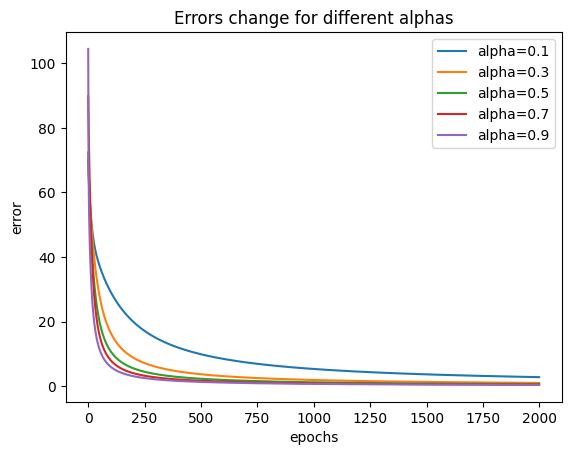

In [17]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

for alpha in alphas:
    logistic_regression = LogisticRegression(X_scaled, y)
    logistic_regression.train(max_epochs=2000, alpha=alpha)
    
    errors = logistic_regression.get_errors_history()
    
    plt.plot(errors, label=f'alpha={alpha}')

plt.title('Errors change for different alphas')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()

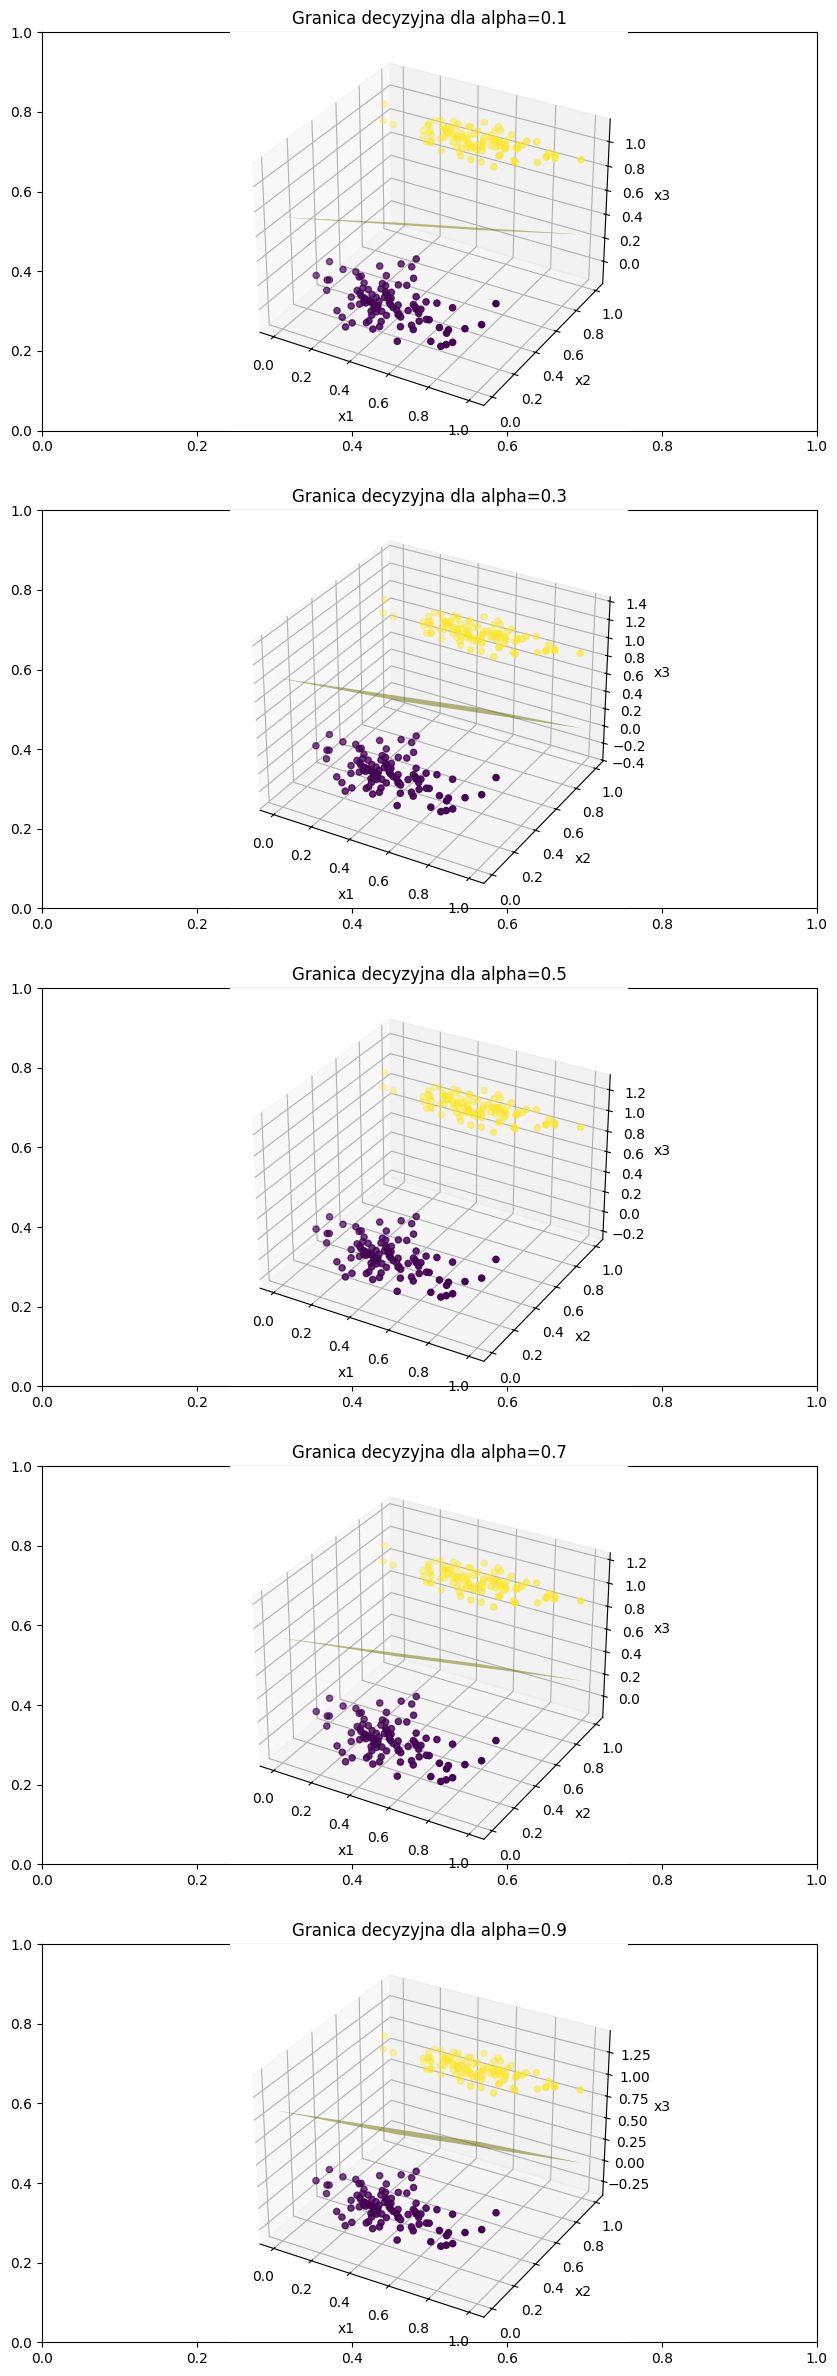

In [18]:
fig, axs = plt.subplots(len(alphas), figsize=(10, 30))

for i, alpha in enumerate(alphas):
    logistic_regression = LogisticRegression(X_scaled, y)
    logistic_regression.train(alpha=alpha)
    
    weights = logistic_regression.get_weights_history()[-1]

    x1, x2 = np.meshgrid(np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 10),
                        np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 10))

    ax = fig.add_subplot(len(alphas), 1, i+1, projection='3d')

    x3 = -(weights[0] + weights[1] * x1 + weights[2] * x2) / weights[3]
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y)
    ax.plot_surface(x1, x2, x3, alpha=0.5, rstride=100, cstride=100, color='y')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    ax.set_title(f'Granica decyzyjna dla alpha={alpha}')

plt.show()